### 1. Imports

In [31]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import re
from matplotlib_venn import venn3


### 2: File paths

In [32]:
data_path = "../../data/processed/processed_bunker_sentiment.pkl"
df_sentiment = pd.read_pickle("df_with_sentiment.pkl")

In [33]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
df_sentiment["sentiment_label"] = df_sentiment["predicted_label"].map(label_map)

### 3: Load and filter data

In [34]:
df = pd.read_pickle(data_path, )
bunker_counts = df["bunker_name"].value_counts()
valid_bunkers = bunker_counts[bunker_counts >= 100].index
df = df[df["bunker_name"].isin(valid_bunkers)].copy()
print(f"Filtered to {len(valid_bunkers)} bunkers with >= 100 reviews")

Filtered to 6 bunkers with >= 100 reviews


In [ ]:
# Combine review-related columns if necessary (assumes a 'review' column)
text_column = "review"  # Change if needed

# Define keyword lists
appearance_keywords = [
    # Structural
    "crack", "cracked", "cracks", "fracture", "fractured", "fractures",
    "damage", "damaged", "damages", "ruin", "ruined", "ruins",
    "degrade", "degraded", "degrading", "deteriorate", "deteriorated", "deteriorating",
    "broken", "crumbling", "collapse", "collapsed", "disintegration", "disintegrated",
    "wear", "worn", "eroded", "erosion", "weathered", "weathering",
    "unstable", "unsafe", "risky", "dangerous", "sagging", "tilting", "leaning", "falling apart",
    # Biological
    "moss", "mould", "mold", "mildew", "lichen", "lichens", "algae", "fungi",
    "vegetation", "overgrown", "undergrowth", "plants", "biological proliferation", "nature taking over", "wild growth",
    # Moisture
    "humidity", "moist", "moisture", "damp", "wet", "leaking", "leak", "leakage",
    "seep", "seepage", "water infiltration", "water damage", "condensation", "stains", "staining", "watermarks",
    # Chemical
    "corrosion", "corroded", "corroding", "rust", "rusty", "rusting", "oxidation", "oxidized", "oxidising",
    "carbonation", "efflorescence", "salt", "salts", "patina", "discoloration", "discolouration",
    # Neglect
    "aging", "aged", "old", "ancient", "neglected", "abandonment", "abandoned",
    "decay", "decayed", "decaying", "derelict", "dilapidated", "decrepit", "rundown", "forgotten", "worn out", "obsolete",
    # Neutral structure
    "bunker", "structure", "fortification", "architecture", "design", "concrete", "steel", "rebar", "pillbox", "gun emplacement", "slab", "walls", "roof",
    "stairs", "floor", "ramp", "entrance", "corridor", "hallway", "layout", "blast door", "turret", "observation post", "viewpoint", "ventilation", "interior", "exterior"

]

experience_keywords = [
    # Positive emotional tone
    "amazing", "incredible", "fantastic", "impressive", "beautiful", "breathtaking", 
    "moving", "touching", "memorable", "fascinating", "worth", "worthwhile", 
    "recommend", "recommended", "recommendation", "enjoy", "enjoyed", "enjoyable",
    "interesting", "well done", "insightful", "educational", "authentic", "immersive",
    # Guided experiences
    "guide", "guided", "tour", "tours", "touring", "informative", "narrative", 
    "presentation", "explanation", "exhibit", "exhibits", "exhibition", "museum",
    # Atmosphere/setting
    "atmosphere", "ambience", "setting", "layout", "lighting", "sound", "audioguide",
    "interactive", "display", "displays", "organized", "organization", "clean", "accessible",
    # Engagement/Facilities
    "children", "family", "engaging", "hands-on", "staff", "friendly", "helpful", "service",
    "welcome", "welcoming", "ticket", "booking", "shop", "cafe", "accessibility", "signage",
    # Neutral
    "visit", "visited", "location", "area", "place", "time", "group", "duration", "walk", "drive", "entrance", "path", "parking", "queue", "opening hours", "timing",

    # Negative experience / service / facilities
    "boring", "disappointing", "unimpressive", "underwhelming", "uninteresting", "confusing", "inaccessible", "poor", "bad", "rude", "unfriendly", "unhelpful",
    "overpriced", "expensive", "crowded", "noisy", "dirty", "messy", "cluttered", "poorly organized", "hard to find", "not worth", "waste of time",
    "misleading", "broken", "out of order", "uncomfortable", "awkward","too short", "too long", "not informative", "lack of explanation",
    "missing signs", "bad signage", "no parking", "no toilets", "queue", "long wait"
]

historical_keywords = [
    "ww2", "world war", "second world war", "nazis", "germans", "allies", "occupation",
    "liberation", "soldier", "soldiers", "military", "war", "battles", "bomb", "bombing",
    "gun", "guns", "artillery", "history", "historical", "archive", "memorabilia", "uniform",
    "propaganda", "resistance", "forces", "army", "conflict", "fortification", "defense", 
    "strategy", "defensive", "radar", "command", "intelligence", "spy", "reenactment"
]

# Lowercase keyword lists for uniformity
def normalize_keywords(keywords):
    return list(set([kw.lower() for kw in keywords]))

appearance_keywords = normalize_keywords(appearance_keywords)
experience_keywords = normalize_keywords(experience_keywords)
historical_keywords = normalize_keywords(historical_keywords)

# Function to detect keyword presence
def contains_keywords(text, keyword_list):
    if not isinstance(text, str):
        return False
    text = text.lower()
    return any(re.search(rf'\b{re.escape(kw)}\b', text) for kw in keyword_list)

# Apply to dataframe
df_sentiment["is_appearance"] = df_sentiment[text_column].apply(lambda x: contains_keywords(x, appearance_keywords))
df_sentiment["is_experience"] = df_sentiment[text_column].apply(lambda x: contains_keywords(x, experience_keywords))
df_sentiment["is_historical"] = df_sentiment[text_column].apply(lambda x: contains_keywords(x, historical_keywords))

# Optional: summarize number of reviews per category
category_counts = df_sentiment[["is_appearance", "is_experience", "is_historical"]].sum()
print("Category counts:\n", category_counts)

# Optional: aggregate sentiment by category
category_sentiment = {
    "appearance": df_sentiment[df_sentiment["is_appearance"]]["predicted_label"].value_counts(normalize=True),
    "experience": df_sentiment[df_sentiment["is_experience"]]["predicted_label"].value_counts(normalize=True),
    "historical": df_sentiment[df_sentiment["is_historical"]]["predicted_label"].value_counts(normalize=True),
}

print("\nSentiment distribution by category:")
for cat, dist in category_sentiment.items():
    print(f"\n{cat.capitalize()}:\n{dist}")




Category counts:
 is_appearance     1647
is_experience    10683
is_historical     2488
dtype: int64

Sentiment distribution by category:

Appearance:
predicted_label
2    0.763206
1    0.144505
0    0.092289
Name: proportion, dtype: float64

Experience:
predicted_label
2    0.858467
1    0.083684
0    0.057849
Name: proportion, dtype: float64

Historical:
predicted_label
2    0.816720
1    0.139469
0    0.043810
Name: proportion, dtype: float64



Appearance — 1647 reviews
sentiment_label
positive    0.763206
neutral     0.144505
negative    0.092289
Name: proportion, dtype: float64

Experience — 10683 reviews
sentiment_label
positive    0.858467
neutral     0.083684
negative    0.057849
Name: proportion, dtype: float64

Historical — 2488 reviews
sentiment_label
positive    0.816720
neutral     0.139469
negative    0.043810
Name: proportion, dtype: float64

Final Data for Plot:
             positive   neutral  negative
Appearance  0.763206  0.144505  0.092289
Experience  0.858467  0.083684  0.057849
Historical  0.816720  0.139469  0.043810


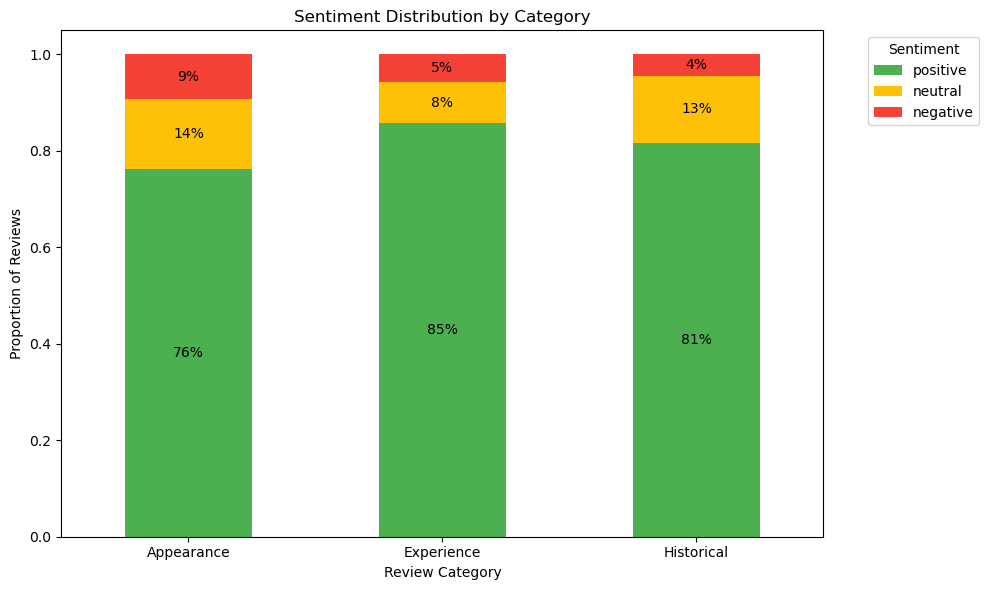

In [36]:
def plot_sentiment_distribution(df):
    categories = ["appearance", "experience", "historical"]
    sentiment_types = ["positive", "neutral", "negative"]
    colors = {"positive": "#4CAF50", "neutral": "#FFC107", "negative": "#F44336"}

    summary = {}
    for cat in categories:
        flag = f"is_{cat}"
        subset = df[df[flag]]
        print(f"\n{cat.capitalize()} — {len(subset)} reviews")
        sentiment_counts = subset["sentiment_label"].value_counts(normalize=True)
        print(sentiment_counts)

        summary[cat.capitalize()] = {
            s: sentiment_counts.get(s, 0) for s in sentiment_types
        }

    df_plot = pd.DataFrame(summary).T
    print("\nFinal Data for Plot:\n", df_plot)

    if df_plot.sum().sum() == 0:
        print("Nothing to plot — all values are 0.")
        return

    ax = df_plot.plot(kind="bar", stacked=True, color=[colors[s] for s in sentiment_types], figsize=(10, 6))
    plt.title("Sentiment Distribution by Category")
    plt.ylabel("Proportion of Reviews")
    plt.xlabel("Review Category")
    plt.xticks(rotation=0)
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

    for i, row in enumerate(df_plot.values):
        y_offset = 0
        for j, val in enumerate(row):
            if val > 0.03:
                plt.text(i, y_offset + val / 2, f"{int(val * 100)}%", ha='center', va='center', fontsize=10)
            y_offset += val

    plt.tight_layout()
    plt.show()

plot_sentiment_distribution(df_sentiment)


/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_1391/18637368.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


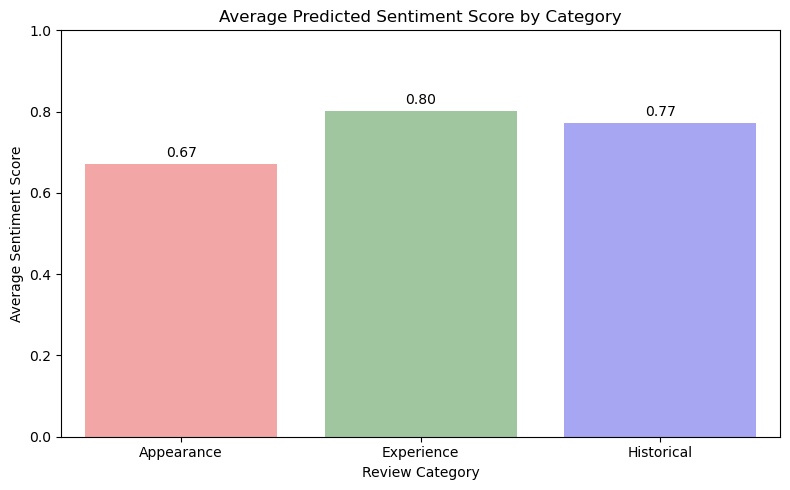

In [37]:
def plot_average_sentiment_by_category(df):
    categories = ["appearance", "experience", "historical"]
    avg_scores = {}

    for cat in categories:
        flag = f"is_{cat}"
        subset = df[df[flag]]
        if not subset.empty:
            avg_score = subset["sentiment_score"].mean()
            avg_scores[cat.capitalize()] = avg_score
        else:
            avg_scores[cat.capitalize()] = None

    # Theme-matching colors (from your Venn diagram)
    themed_colors = ["#FF9999", "#99CC99", "#9999FF"]  # Appearance, Experience, Historical

    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=list(avg_scores.keys()),
        y=list(avg_scores.values()),
        palette=themed_colors
    )
    plt.title("Average Predicted Sentiment Score by Category")
    plt.ylabel("Average Sentiment Score")
    plt.xlabel("Review Category")
    plt.ylim(0, 1)

    for i, score in enumerate(avg_scores.values()):
        if score is not None:
            plt.text(i, score + 0.01, f"{score:.2f}", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()

plot_average_sentiment_by_category(df_sentiment)


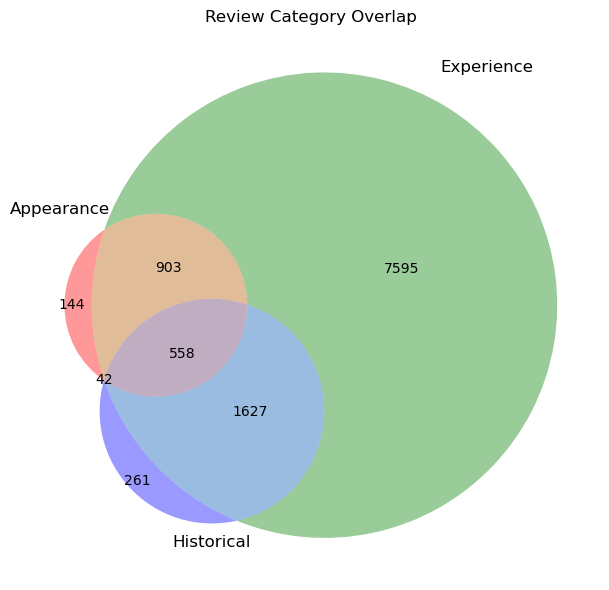

In [38]:
def plot_category_overlap(df):
    set_appearance = set(df[df["is_appearance"]].index)
    set_experience = set(df[df["is_experience"]].index)
    set_historical = set(df[df["is_historical"]].index)

    plt.figure(figsize=(8, 6))
    venn3([set_appearance, set_experience, set_historical],
          set_labels=("Appearance", "Experience", "Historical"))
    plt.title("Review Category Overlap")
    plt.tight_layout()
    plt.show()

plot_category_overlap(df_sentiment)



In [58]:
def print_sample_reviews(df):
    categories = {
        "Appearance": "is_appearance",
        "Experience": "is_experience",
        "Historical": "is_historical"
    }

    sentiment_labels = {0: "Negative", 2: "Positive"}

    for cat_name, cat_flag in categories.items():
        print(f"\n=== {cat_name.upper()} ===")

        for sentiment_value, sentiment_name in sentiment_labels.items():
            subset = df[(df[cat_flag]) & (df["predicted_label"] == sentiment_value)]

            if not subset.empty:
                sample = subset.sample(1)  # No fixed seed
                text = sample["review"].values[0]
                print(f"\n{sentiment_name} Review:\n{text}")
            else:
                print(f"\n{sentiment_name} Review:\nNo reviews found.")

# Usage
print_sample_reviews(df_sentiment)



=== APPEARANCE ===

Negative Review:
Don't visit this place, you won't see what's in the photo anymore. Namely the rear part and the entrance barriers.

Positive Review:
An incredibly interesting museum in a Soviet submarine at the Hamburg fish market. ⚓️🌊
I can highly recommend a visit! ⭐️⭐️⭐️⭐️⭐️
You can tour the submarine as part of a booked tour or individually (Info: the command center is only included in the tour).
Everything is very well preserved, clean and very well maintained.
In some places it can be a bit tighter as you have to walk through narrow corridors, small hatches or doors or climb/down narrow, steep stairs.
It is not only suitable for those interested in technology but is simply very exciting in general! In general it is something different and a special experience for young, old and also for families with children.

=== EXPERIENCE ===

Negative Review:
The visit is free fortunately because all these bases are similar, after that I did not visit the places which w